In [114]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import statistics as st
from skimage import util

In [126]:
img = cv2.imread('Images/future.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(300, 350))
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

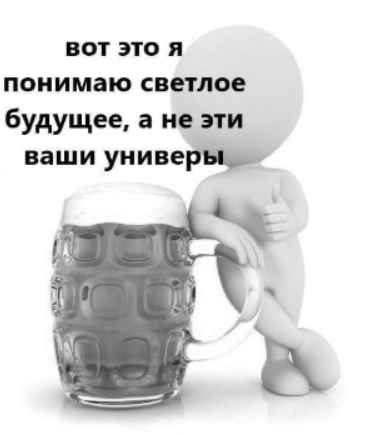

In [127]:
def mean(xs): 
    xs=np.array(xs)
    return sum(sum(xs)) / (xs.shape[0]*xs.shape[1])

def variance(xs):
    xs=np.array(xs)
    mu = mean(xs)
    n = (xs.shape[0]*xs.shape[1])
    S=np.sqrt(sum(sum((xs-mean(xs))**2))/n)
    return S

def covariance(xs,ys):
    xs=np.array(xs)
    ys=np.array(ys)
    return mean((xs-mean(xs))*(ys-mean(ys)))
    
def SSIM(imgx,imgy):
    imgx=np.array(imgx)
    imgy=np.array(imgy)
    mx=mean(imgx)
    my=mean(imgy)
    sigmax=variance(imgx)
    sigmay=variance(imgy)
    cov=covariance(imgx,imgy)
    c1=(0.01*255)**2
    c2=(0.03*255)**2
    ssim=(2*mx*my+c1)*(2*cov+c2)/((mx**2+my**2+c1)*(sigmax**2+sigmay**2+c2))
    return ssim

In [128]:
#add gausse
image = np.array(img)
image_gauss=util.random_noise(image, mode='gaussian')
#print(type(image_gauss))
print('PSNR =',cv2.PSNR(np.array(image_gauss,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(image_gauss, img))
cv2.imshow('image_gauss', image_gauss)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 1.1768527588551958 Db
SSIM = 0.0016313555387554941


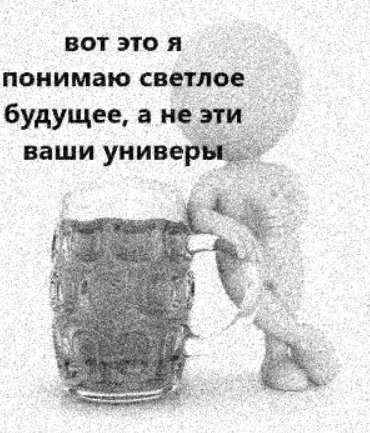

In [129]:
#mean arifmetic
mean_arif=cv2.blur(image_gauss,[5,5])
print('PSNR =',cv2.PSNR(np.array(mean_arif,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(mean_arif, img))
cv2.imshow('mean_arifmetic', mean_arif)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 1.1644417731977932 Db
SSIM = 0.0015369158886754926


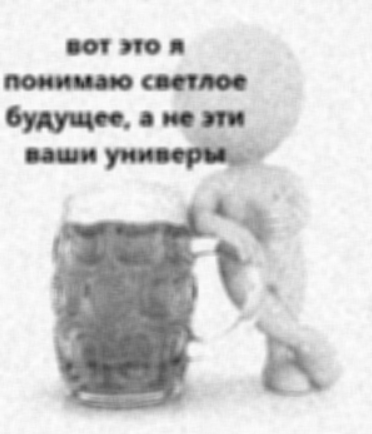

In [130]:
def GeometricMeanOperator(roi):
    roi = roi.astype(np.float64)
    p = np.prod(roi)
    return p ** (1 / (roi.shape[0] * roi.shape[1]))

def GeometricMeanAlgorithm(image):
    # Геометрическая средняя фильтрация
    new_image = np.zeros(image.shape)
    image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            new_image[i - 1, j - 1] = GeometricMeanOperator(image[i - 1:i + 2, j - 1:j + 2])
    new_image = (new_image - np.min(image)) * (255 / np.max(image))
    return new_image.astype(np.uint8)

In [131]:
#mean geometric
mean_geom=GeometricMeanAlgorithm(image_gauss)
print('PSNR =',cv2.PSNR(np.array(mean_geom,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(mean_geom, img))
cv2.imshow('mean_geometric', mean_geom)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 19.626965492732623 Db
SSIM = 0.9925214423994724


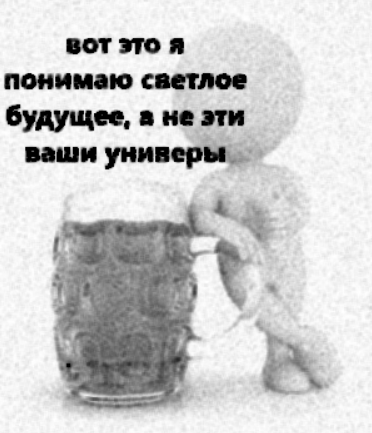

In [132]:
import random
def salt_pepper(image,percent):
    row,col=image.shape
    number_pixels=round(image.size*percent/100)
    for i in range(number_pixels):
        x_salt=random.randint(0,row-1)
        y_salt=random.randint(0,col-1)
        image[x_salt][y_salt]=255
        x_pepper=random.randint(0,row-1)
        y_pepper=random.randint(0,col-1)
        image[x_pepper][y_pepper]=0
    return image

In [133]:
#salt and pepper
image = np.array(img)
image_sp=salt_pepper(image,0.7)
print('PSNR =',cv2.PSNR(np.array(image_sp,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(image_sp, img))
cv2.imshow('salt_and_pepper', image_sp)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 22.34575012148875 Db
SSIM = 0.9961073369616147


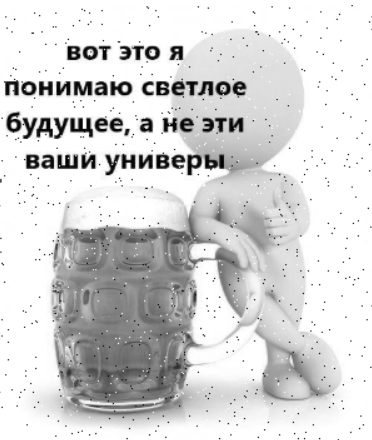

In [134]:
#median filter
med_filt=cv2.medianBlur(image_sp,3)
print('PSNR =',cv2.PSNR(np.array(med_filt,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(med_filt, img))
cv2.imshow('median_filter', med_filt)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 27.959584615688563 Db
SSIM = 0.9989290795272315


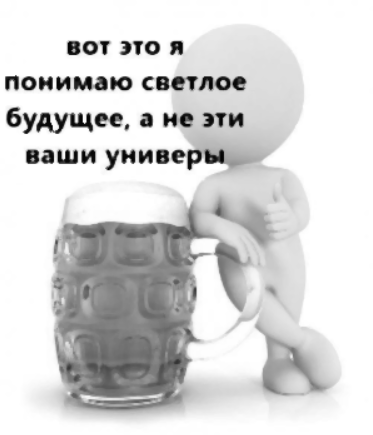

In [136]:
def adaptive_median_filter(src_image, kernel_size):
    height, width = src_image.shape
    num = height * width
    src_after_filter = np.zeros_like(src_image, dtype="float64")
    for i in range(height):
        print(i,'/',height)
        for j in range(width):
            rst = filter_process(src_image, kernel_size, i, j, 7)
            src_after_filter[i][j] = rst
    return src_after_filter

def filter_process(src_image, kernel_size, i, j, s_max=7):
    edge_size = int(kernel_size / 2)
    padded_img = np.pad(src_image, edge_size, 'edge')
    box = padded_img[i:i + kernel_size, j:j + kernel_size]
    z_min = np.min(box)
    z_max = np.max(box)
    z_med = np.median(box)
    z_xy = src_image[i, j]
    rst = a_process(src_image, kernel_size, i, j, s_max, z_xy, z_min, z_max, z_med)
    return rst

def a_process(src_image, kernel_size, i, j, s_max, z_xy, z_min, z_max, z_med):
    A1 = z_med - z_min
    A2 = z_med - z_max
    if A1 > 0 and A2 < 0:
        return b_process(z_xy, z_min, z_max, z_med)
    elif (kernel_size + 2) <= s_max:
        return filter_process(src_image, kernel_size + 2, i, j, s_max)
    else:
        return z_med

def b_process(z_xy, z_min, z_max, z_med):
    B1 = z_xy - z_min
    B2 = z_xy - z_max
    if B1 > 0 and B2 < 0:
        return z_xy
    else:
        return z_med

In [139]:
#adaptive median filter
adapt_med_filt = adaptive_median_filter(image_sp.astype(float), 3)
print('PSNR =',cv2.PSNR(np.array(adapt_med_filt,dtype=np.uint8),img),'Db')
print('SSIM =',SSIM(adapt_med_filt, img))
cv2.imshow('adapt_med_filt', adapt_med_filt)
cv2.waitKey(0)
cv2.destroyAllWindows()

PSNR = 35.20294722597965 Db
SSIM = 0.9989290795272315


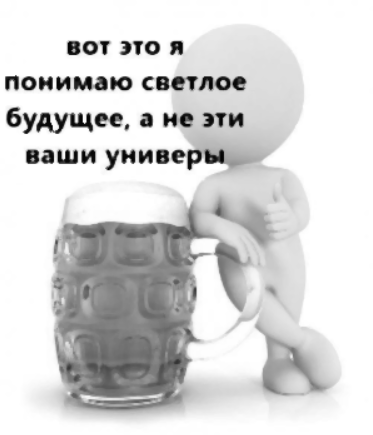